In [1]:
import gym
import d4rl
import torch
import numpy as np
import pandas as pd
import eval_utils.plotter as plotter

These new versions include large bug fixes, new versions of Python, and are where all new development will continue. Please upgrade these libraries as soon as you're able to do so.
If you'd like to read more about the story behind this switch, please check out ]8;;https://farama.org/Announcing-Minari\this blog post]8;;\.
/home/niclas/anaconda3/envs/orl/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


In [2]:
model_paths = {}

In [3]:
# halfcheetah-medium-v2
combo_model_halfcheetah_benchmark = "models/halfcheetah-medium-v2_combo_benchmark_policy_model.pt"
combo_model_halfcheetah_filtered = "models/halfcheetah-medium-v2_combo_filtered_policy_model.pt"

mobile_model_halfcheetah_benchmark = "models/halfcheetah-medium-v2_mobile_benchmark_policy_model.pt"
mobile_model_halfcheetah_filtered = "models/halfcheetah-medium-v2_mobile_filtered_policy_model.pt"

model_paths["halfcheetah-medium-v2"] = {
    "combo_benchmark": combo_model_halfcheetah_benchmark,
    "combo_filtered": combo_model_halfcheetah_filtered,
    "mobile_benchmark": mobile_model_halfcheetah_benchmark,
    "mobile_filtered": mobile_model_halfcheetah_filtered
}

In [4]:
# hopper-medium-v2
combo_model_hopper_benchmark = "models/hopper-medium-v2_combo_benchmark_policy_model.pt"
combo_model_hopper_filtered = "models/hopper-medium-v2_combo_filtered_policy_model.pt"

mobile_model_hopper_benchmark = "models/hopper-medium-v2_mobile_benchmark_policy_model.pt"
mobile_model_hopper_filtered = "models/hopper-medium-v2_mobile_filtered_policy_model.pt"

model_paths["hopper-medium-v2"] = {
    "combo_benchmark": combo_model_hopper_benchmark,
    "combo_filtered": combo_model_hopper_filtered,
    "mobile_benchmark": mobile_model_hopper_benchmark,
    "mobile_filtered": mobile_model_hopper_filtered
}

In [5]:
# walker2d-medium-v2
combo_model_walker_benchmark = "models/walker2d-medium-v2_combo_benchmark_policy_model.pt"
combo_model_walker_filtered = "models/walker2d-medium-v2_combo_filtered_policy_model.pt"

mobile_model_walker_benchmark = "models/walker2d-medium-v2_mobile_benchmark_policy_model.pt"
mobile_model_walker_filtered = "models/walker2d-medium-v2_mobile_filtered_policy_model.pt"

model_paths["walker2d-medium-v2"] = {
    "combo_benchmark": combo_model_walker_benchmark,
    "combo_filtered": combo_model_walker_filtered,
    "mobile_benchmark": mobile_model_walker_benchmark,
    "mobile_filtered": mobile_model_walker_filtered
}

In [6]:
def rollout_env(env_name, policy_model_path, num_episodes=10, get_normalized_score=False, verbose=False):
    env = gym.make(env_name)
    policy = torch.load(policy_model_path)
    policy.eval()

    total_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action = policy(state_tensor).squeeze(0)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
        if verbose:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}, Model: {policy_model_path}")
    total_rewards = np.array(total_rewards)
    if get_normalized_score:
        normalized_scores = env.get_normalized_score(total_rewards)
        return normalized_scores * 100
    return total_rewards

In [7]:
tasks = ["hopper-medium-v2","halfcheetah-medium-v2", "walker2d-medium-v2"]
get_normalized_score = True
n_episodes = 100

In [8]:
summary = {}

/home/niclas/anaconda3/envs/orl/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
2025-09-09 21:27:21.537847: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 21:27:21.572534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-09 21:27:22.254421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/niclas/anaconda3/en

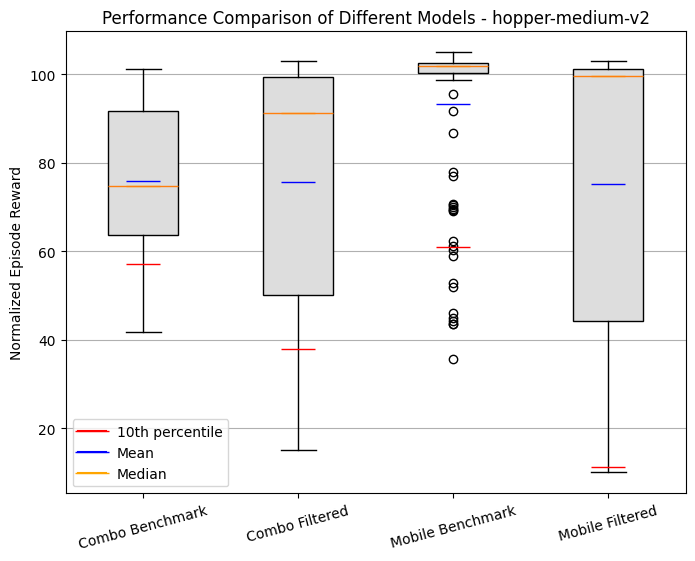

/home/niclas/anaconda3/envs/orl/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


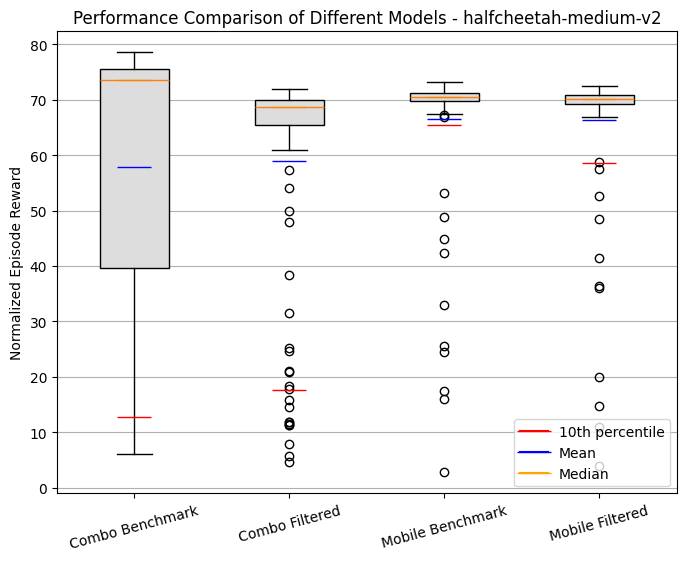

/home/niclas/anaconda3/envs/orl/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


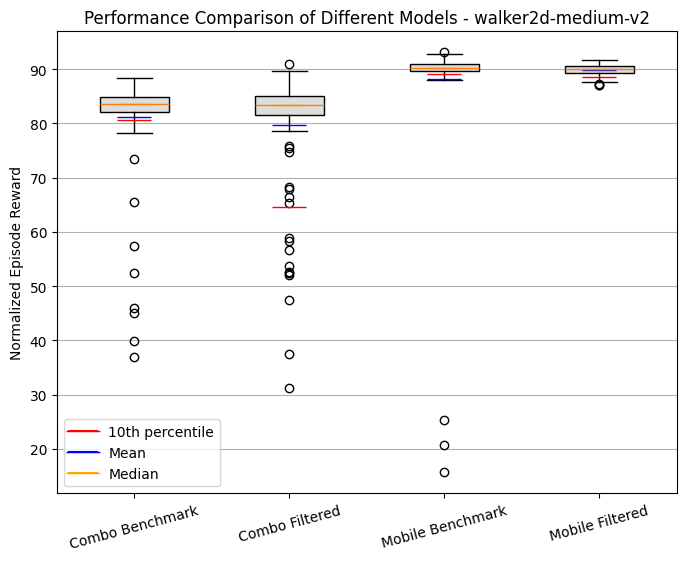

In [9]:
for task in tasks:
    combo_rewards = rollout_env(task, model_paths[task]["combo_benchmark"], num_episodes=n_episodes, get_normalized_score=get_normalized_score)
    combo_rewards_filtered = rollout_env(task, model_paths[task]["combo_filtered"], num_episodes=n_episodes, get_normalized_score=get_normalized_score)
    mobile_rewards = rollout_env(task, model_paths[task]["mobile_benchmark"], num_episodes=n_episodes, get_normalized_score=get_normalized_score)
    mobile_rewards_filtered = rollout_env(task, model_paths[task]["mobile_filtered"], num_episodes=n_episodes, get_normalized_score=get_normalized_score)

    data = [
        combo_rewards,
        combo_rewards_filtered,
        mobile_rewards,
        mobile_rewards_filtered
    ]
    labels = [
        "Combo Benchmark",
        "Combo Filtered",
        "Mobile Benchmark",
        "Mobile Filtered"
    ]
    title = f"Performance Comparison of Different Models - {task}"
    plotter.boxplot_rewards(data, labels, title, y_label="Normalized Episode Reward")

    # write result in summary dict
    summary[task] = {
        "Combo Benchmark": {
            "mean": np.mean(combo_rewards),
            "std": np.std(combo_rewards),
            "min": np.min(combo_rewards),
            "max": np.max(combo_rewards),
            "all_rewards": combo_rewards.tolist(),
        },
        "Combo Filtered": {
            "mean": np.mean(combo_rewards_filtered),
            "std": np.std(combo_rewards_filtered),
            "min": np.min(combo_rewards_filtered),
            "max": np.max(combo_rewards_filtered),
            "all_rewards": combo_rewards_filtered.tolist(),
        },
        "Mobile Benchmark": {
            "mean": np.mean(mobile_rewards),
            "std": np.std(mobile_rewards),
            "min": np.min(mobile_rewards),
            "max": np.max(mobile_rewards),
            "all_rewards": mobile_rewards.tolist(),
        },
        "Mobile Filtered": {
            "mean": np.mean(mobile_rewards_filtered),
            "std": np.std(mobile_rewards_filtered),
            "min": np.min(mobile_rewards_filtered),
            "max": np.max(mobile_rewards_filtered),
            "all_rewards": mobile_rewards_filtered.tolist(),
        },
    }
    

In [10]:
rows = []
for task, results in summary.items():
    for model, stats in results.items():
        row = {
            "Task": task,
            "Model": model,
            "Mean": stats["mean"],
            "Std": stats["std"],
            "Min": stats["min"],
            "Max": stats["max"],
            "P10": np.percentile(stats["all_rewards"], 10),
        }
        rows.append(row)

results_df = pd.DataFrame(rows)
results_mean = results_df.pivot(index="Task", columns="Model", values="Mean")
print("Mean Reward Scores:")
display(results_mean)
results_p10 = results_df.pivot(index="Task", columns="Model", values="P10")
print("P10 Reward Scores:")
display(results_p10)

Mean Reward Scores:


Model,Combo Benchmark,Combo Filtered,Mobile Benchmark,Mobile Filtered
Task,,,,
halfcheetah-medium-v2,57.935014,58.946429,66.525898,66.278299
hopper-medium-v2,75.821923,75.610912,93.158046,75.133530
walker2d-medium-v2,81.217737,79.669183,88.273332,89.890999


P10 Reward Scores:


Model,Combo Benchmark,Combo Filtered,Mobile Benchmark,Mobile Filtered
Task,,,,
halfcheetah-medium-v2,12.663528,17.676035,65.488896,58.569843
hopper-medium-v2,57.088657,37.895675,61.031809,11.297387
walker2d-medium-v2,80.593801,64.597125,89.071093,88.506195


## Findings & Discussion
- No significant improvement due to filtering

- It seems like the filtering mechanism in some cases rather filtered out transitions that contain useful information than noise that spoils the training process.

- Tuning hyperparameters such as the filtering criteria and thresholds as well as the regularization strength and rollout length in the filtered setting might result in better performances, but a significant advantage of filtering is unlikely to be found in the tested tasks.

- A setting in which filtering might be more beneficial would be on a smaller dataset, which leads to a less accurate dynamics ensemble. That model might produce synthetic data that includes more transitions that are inaccurate enough that they are worth being filtered out.
Researchers can test this by conducting the same experiments on subsets of the used medium datasets.
 
- To better analyze if noise or useful information is filtered out, comparisons between the distributions of synthetically created data and the given dataset can be made based on mutual information or with a discriminator model. A discriminator model can also directly be used for filtering during training to replace the threshhold-based approach on uncertainty measures.